**Author:** Luis Antonio Haddock III (TCF Lab)  
> **Created on:** 2022-10-25  
> **Last updated:** 2022-11-01 


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from pandas.plotting import table
import seaborn as sns
from scipy import stats
from statistics import mean
from scipy.integrate import quad
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import csv
from pathlib import Path
import numpy as np
import json
import requests
import datetime
from scipy.stats import binomtest
from Bio import SeqIO
from scipy.stats.contingency import relative_risk
from scipy.stats import binomtest
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Structure of input files

> 1. VCF file called with `ivar variants` and annotatedd with `SPNEff`.
> 2. June timepoint file -> `D3_20220616`
> 3. August timepoint file -> `D3_20220816` 



In [3]:
def format_snpeff_output(timepoint):
    df = pd.read_csv('timepoints/'+timepoint+'/'+timepoint+'_isnv.ann.vcf', skiprows=6, sep='\t')
    df.columns = ["STRAIN", 'POS','ID', 'REF', 'ALT', 'QUAL', 'FILTER', "INFO"]
    df['INFO'] = df['INFO'].apply(str)

    #splitting INFO column because bcftools query was not working properly


    df_split = df["INFO"]
    df_split = pd.DataFrame(df_split)
    df_split = df_split.INFO.str.split(";", expand=True)
    df_split

    df_DP = df_split[0]
    df_DP =  df_DP.str[3:]
    df_DP = pd.DataFrame(df_DP)
    df['DP'] = df_DP.astype(int)

    df_AF = df_split[1]
    df_AF =  df_AF.str[3:]
    df_AF = pd.DataFrame(df_AF)
    df['AF'] = df_AF.astype(float)

    df_INFO = df_split[2]
    df_INFO = pd.DataFrame(df_INFO)
    df['INFO'] = df_INFO

    df = df[["STRAIN", 'POS', 'REF', 'ALT', 'DP', 'AF', "INFO"]]

    df['INFO'] = df['INFO'].apply(str)
    df['STRAIN'] = df['STRAIN'].apply(str)

    #aa change
    df_aa = df["INFO"]
    df_aa = pd.DataFrame(df_aa)
    df_sub = df_aa.INFO.str.split("|", expand=True)


    df_aa_subset = df_sub[10]
    df_aa_subset = pd.DataFrame(df_aa_subset)

    df_var_subset = df_sub[1]
    df_var_subset = pd.DataFrame(df_var_subset)

    #gene column

    df_gene = df_sub[3]
    df_gene = pd.DataFrame(df_gene)

    df['AA_change'] = df_aa_subset
    df['GENE'] = df_gene
    df['Var_type'] = df_var_subset

    df = df[['GENE', 'POS', 'REF', 'ALT', 'DP', 'AF', 'AA_change', 'Var_type']]

    #cleaning the protein column
    df['AA_change'] = df['AA_change'].apply(str)
    df_protein = df["AA_change"]
    df_protein = pd.DataFrame(df_protein)
    df_protein = df_protein.AA_change.str.split(".", expand=True)
    df_protein = df_protein[1]
    df_protein = pd.DataFrame(df_protein)

    df['SNV'] = df_protein
    df = df[['GENE', 'POS', 'REF', 'ALT', 'DP', 'AF', 'Var_type', 'SNV']]

    df.loc[df['Var_type'].str.startswith('upstream'), 'annotation'] = 'inter'
    df.loc[df['Var_type'].str.startswith('downstream'), 'annotation'] = 'inter'
    df.loc[df['Var_type'].str.startswith('synonymous'), 'annotation'] = 'syn'
    df.loc[df['Var_type'].str.startswith('missense'), 'annotation'] = 'ns'
    df.loc[df['Var_type'].str.startswith('stop'), 'annotation'] = 'stop'
    df.loc[df['Var_type'].str.startswith('frameshift'), 'annotation'] = 'frameshift'
    df.loc[df['Var_type'].str.startswith('conservative'), 'annotation'] = 'insertion'
    df.loc[df['Var_type'].str.startswith('disruptive'), 'annotation'] = 'deletion'

    df['first_aa'] = df['SNV'].str[:3]
    df['last_aa'] = df['SNV'].str[-3:]
    df['aa_pos'] = df['SNV'].str[3:]
    df['aa_pos'] = df['aa_pos'].str[:-3]

    df=df.replace({"first_aa": mapping, "last_aa": mapping})
    df['aa_change'] = df['first_aa'] + df['aa_pos'] + df['last_aa']

    df['iSNV'] = df['GENE'] + "_" + df['REF'] + df['POS'].astype(str) + df['ALT'] + "_" + df['aa_change'] + "_" + df['annotation']
    df['iSNV'] = df['iSNV'].fillna('intergenic')

    df = df[['iSNV', 'AF', 'Var_type', 'SNV', 'annotation']]
    
    df.to_csv('timepoints/'+timepoint+'/'+timepoint+'_cleaned_isnv.csv', sep='\t')




In [4]:
aa_dict = {"A":"Ala","R":"Arg","N":"Asn","D":"Asp","C":"Cys","Q":"Gln","E":"Glu","G":"Gly","H":"His",
           "I":"Ile","L":"Leu","K":"Lys","M":"Met","F":"Phe","P":"Pro","S":"Ser","T":"Thr","W":"Trp",
           "Y":"Tyr","V":"Val", "*":"stop"}

mapping = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C','Gln':'Q','Glu':'E','Gly':'G','His':'H',
           'Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Ser':'S','Thr':'T','Trp':'W',
           'Tyr':'Y','Val':'V'}

In [5]:
#Cleaning timepoints
format_snpeff_output('D3_20220616')

format_snpeff_output('D3_20220816')

In [6]:
def extracting_sfs_syn(timepoint):
    df = pd.read_csv('timepoints/'+timepoint+'/'+ timepoint +'_cleaned_isnv.csv', sep='\t')
    df = df[df.iSNV.str.contains("syn")]
    df = df[['AF']]
    SFS = df.apply(pd.Series.value_counts, bins=[.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.99])
    SFS = SFS.sort_index(ascending=True)
    sums = SFS['AF'].sum()
    SFS['proportion_of_iSNVs'] = SFS['AF'] / sums
    SFS = SFS[['proportion_of_iSNVs']]
    SFS = SFS.rename(columns={'proportion_of_iSNVs':timepoint+'_syn'})
    #set bins
    SFS['bins'] = ['25-35%','35-45%','45-55%','55-65%','65-75%','75-85%','85-95%','95-99%']
    final = SFS.set_index('bins')
    final.to_csv('timepoints/'+timepoint+'/'+ timepoint +'_SFS_syn.csv', sep='\t')    
    final    
    
#extracting non-syn info

def extracting_sfs_nonsyn(timepoint):
    df = pd.read_csv('timepoints/'+timepoint+'/'+ timepoint +'_cleaned_isnv.csv', sep='\t')
    df = df[~df.iSNV.str.contains("syn")]
    df = df[['AF']]
    SFS = df.apply(pd.Series.value_counts, bins=[.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.99])
    SFS = SFS.sort_index(ascending=True)
    sums = SFS['AF'].sum()
    SFS['proportion_of_iSNVs'] = SFS['AF'] / sums
    SFS = SFS[['proportion_of_iSNVs']]
    SFS = SFS.rename(columns={'proportion_of_iSNVs':timepoint+'_non_syn'})
    #set bins
    SFS['bins'] = ['25-35%','35-45%','45-55%','55-65%','65-75%','75-85%','85-95%','95-99%']
    final = SFS.set_index('bins')
    final.to_csv('timepoints/'+timepoint+'/'+ timepoint +'_SFS_nonsyn.csv', sep='\t')    
    final    

In [7]:
#extracting data for Frequency Spectrums (not included in manuscript)

extracting_sfs_syn('D3_20220816')
extracting_sfs_syn('D3_20220616')

extracting_sfs_nonsyn('D3_20220816')
extracting_sfs_nonsyn('D3_20220616')

# Plotting data for manuscript

## Panel B: types of mutations

In [8]:
june_df = pd.read_csv('timepoints/D3_20220616/D3_20220616_isnv.ann.vcf', skiprows=6, sep='\t')
june_df.columns = ["STRAIN", 'POS','ID', 'REF', 'ALT', 'QUAL', 'FILTER', "INFO"]
june_df['INFO'] = june_df['INFO'].apply(str)

#splitting INFO column because bcftools query was not working properly


june_df_split = june_df["INFO"]
june_df_split = pd.DataFrame(june_df_split)
june_df_split = june_df_split.INFO.str.split(";", expand=True)
june_df_split

june_df_DP = june_df_split[0]
june_df_DP =  june_df_DP.str[3:]
june_df_DP = pd.DataFrame(june_df_DP)
june_df['DP'] = june_df_DP.astype(int)

june_df_AF = june_df_split[1]
june_df_AF =  june_df_AF.str[3:]
june_df_AF = pd.DataFrame(june_df_AF)
june_df['AF'] = june_df_AF.astype(float)

june_df_INFO = june_df_split[2]
june_df_INFO = pd.DataFrame(june_df_INFO)
june_df['INFO'] = june_df_INFO

june_df = june_df[["STRAIN", 'POS', 'REF', 'ALT', 'DP', 'AF', "INFO"]]

june_df['INFO'] = june_df['INFO'].apply(str)
june_df['STRAIN'] = june_df['STRAIN'].apply(str)

#aa change
june_df_aa = june_df["INFO"]
june_df_aa = pd.DataFrame(june_df_aa)
june_df_sub = june_df_aa.INFO.str.split("|", expand=True)


june_df_aa_subset = june_df_sub[10]
june_df_aa_subset = pd.DataFrame(june_df_aa_subset)

june_df_var_subset = june_df_sub[1]
june_df_var_subset = pd.DataFrame(june_df_var_subset)

#gene column

june_df_gene = june_df_sub[3]
june_df_gene = pd.DataFrame(june_df_gene)

june_df['AA_change'] = june_df_aa_subset
june_df['GENE'] = june_df_gene
june_df['Var_type'] = june_df_var_subset

june_df = june_df[['GENE', 'POS', 'REF', 'ALT', 'DP', 'AF', 'AA_change', 'Var_type']]

#cleaning the protein column
june_df['AA_change'] = june_df['AA_change'].apply(str)
june_df_protein = june_df["AA_change"]
june_df_protein = pd.DataFrame(june_df_protein)
june_df_protein = june_df_protein.AA_change.str.split(".", expand=True)
june_df_protein = june_df_protein[1]
june_df_protein = pd.DataFrame(june_df_protein)

june_df['SNV'] = june_df_protein
june_df = june_df[['GENE', 'POS', 'REF', 'ALT', 'DP', 'AF', 'Var_type', 'SNV']]

june_df.loc[june_df['Var_type'].str.startswith('upstream'), 'annotation'] = 'other'
june_df.loc[june_df['Var_type'].str.startswith('downstream'), 'annotation'] = 'other'
june_df.loc[june_df['Var_type'].str.startswith('synonymous'), 'annotation'] = 'synonymous'
june_df.loc[june_df['Var_type'].str.startswith('missense'), 'annotation'] = 'non-synonymous'
june_df.loc[june_df['Var_type'].str.startswith('stop'), 'annotation'] = 'other'
june_df.loc[june_df['Var_type'].str.startswith('frameshift'), 'annotation'] = 'other'
june_df.loc[june_df['Var_type'].str.startswith('conservative'), 'annotation'] = 'indel'
june_df.loc[june_df['Var_type'].str.startswith('disruptive'), 'annotation'] = 'indel'

june_df['first_aa'] = june_df['SNV'].str[:3]
june_df['last_aa'] = june_df['SNV'].str[-3:]
june_df['aa_pos'] = june_df['SNV'].str[3:]
june_df['aa_pos'] = june_df['aa_pos'].str[:-3]

june_df=june_df.replace({"first_aa": mapping, "last_aa": mapping})
june_df['aa_change'] = june_df['first_aa'] + june_df['aa_pos'] + june_df['last_aa']

june_df['iSNV'] = june_df['GENE'] + "_" + june_df['REF'] + june_df['POS'].astype(str) + june_df['ALT'] + "_" + june_df['aa_change'] + "_" + june_df['annotation']
june_df['iSNV'] = june_df['iSNV'].fillna('intergenic')
june_df['timepoint'] = 'june'
june_df = june_df[['GENE', 'POS', 'REF', 'ALT','Var_type','first_aa','annotation', 'last_aa','iSNV','timepoint']]
june_df

,GENE,POS,REF,ALT,Var_type,first_aa,annotation,last_aa,iSNV,timepoint
0,orf1ab,100,C,A,upstream_gene_variant,None,other,None,intergenic,june
1,orf1ab,177,T,C,upstream_gene_variant,None,other,None,intergenic,june
2,orf1ab,178,A,G,upstream_gene_variant,None,other,None,intergenic,june
3,orf1ab,292,C,T,synonymous_variant,N,synonymous,N,orf1ab_C292T_N9N_synonymous,june
4,orf1ab,329,C,A,missense_variant,Q,non-synonymous,K,orf1ab_C329A_Q22K_non-synonymous,june
...,...,...,...,...,...,...,...,...,...,...
178,N,28854,C,T,missense_variant,S,non-synonymous,L,N_C28854T_S194L_non-synonymous,june
179,N,29249,C,T,missense_variant,P,non-synonymous,S,N_C29249T_P326S_non-synonymous,june
180,N,29389,A,+AAG,conservative_inframe_insertion,K,indel,dup,N_A29389+AAG_K375dup_indel,june
181,N,29512,T,A,missense_variant,S,non-synonymous,R,N_T29512A_S413R_non-synonymous,june


In [9]:
august_df = pd.read_csv('timepoints/D3_20220816/D3_20220816_isnv.ann.vcf', skiprows=6, sep='\t')
august_df.columns = ["STRAIN", 'POS','ID', 'REF', 'ALT', 'QUAL', 'FILTER', "INFO"]
august_df['INFO'] = august_df['INFO'].apply(str)

#splitting INFO column because bcftools query was not working properly


august_df_split = august_df["INFO"]
august_df_split = pd.DataFrame(august_df_split)
august_df_split = august_df_split.INFO.str.split(";", expand=True)
august_df_split

august_df_DP = august_df_split[0]
august_df_DP =  august_df_DP.str[3:]
august_df_DP = pd.DataFrame(august_df_DP)
august_df['DP'] = august_df_DP.astype(int)

august_df_AF = august_df_split[1]
august_df_AF =  august_df_AF.str[3:]
august_df_AF = pd.DataFrame(august_df_AF)
august_df['AF'] = august_df_AF.astype(float)

august_df_INFO = august_df_split[2]
august_df_INFO = pd.DataFrame(august_df_INFO)
august_df['INFO'] = august_df_INFO

august_df = august_df[["STRAIN", 'POS', 'REF', 'ALT', 'DP', 'AF', "INFO"]]

august_df['INFO'] = august_df['INFO'].apply(str)
august_df['STRAIN'] = august_df['STRAIN'].apply(str)

#aa change
august_df_aa = august_df["INFO"]
august_df_aa = pd.DataFrame(august_df_aa)
august_df_sub = august_df_aa.INFO.str.split("|", expand=True)


august_df_aa_subset = august_df_sub[10]
august_df_aa_subset = pd.DataFrame(august_df_aa_subset)

august_df_var_subset = august_df_sub[1]
august_df_var_subset = pd.DataFrame(august_df_var_subset)

#gene column

august_df_gene = august_df_sub[3]
august_df_gene = pd.DataFrame(august_df_gene)

august_df['AA_change'] = august_df_aa_subset
august_df['GENE'] = august_df_gene
august_df['Var_type'] = august_df_var_subset

august_df = august_df[['GENE', 'POS', 'REF', 'ALT', 'DP', 'AF', 'AA_change', 'Var_type']]

#cleaning the protein column
august_df['AA_change'] = august_df['AA_change'].apply(str)
august_df_protein = august_df["AA_change"]
august_df_protein = pd.DataFrame(august_df_protein)
august_df_protein = august_df_protein.AA_change.str.split(".", expand=True)
august_df_protein = august_df_protein[1]
august_df_protein = pd.DataFrame(august_df_protein)

august_df['SNV'] = august_df_protein
august_df = august_df[['GENE', 'POS', 'REF', 'ALT', 'DP', 'AF', 'Var_type', 'SNV']]

august_df.loc[august_df['Var_type'].str.startswith('upstream'), 'annotation'] = 'other'
august_df.loc[august_df['Var_type'].str.startswith('downstream'), 'annotation'] = 'other'
august_df.loc[august_df['Var_type'].str.startswith('synonymous'), 'annotation'] = 'synonymous'
august_df.loc[august_df['Var_type'].str.startswith('missense'), 'annotation'] = 'non-synonymous'
august_df.loc[august_df['Var_type'].str.startswith('stop'), 'annotation'] = 'other'
august_df.loc[august_df['Var_type'].str.startswith('frameshift'), 'annotation'] = 'other'
august_df.loc[august_df['Var_type'].str.startswith('conservative'), 'annotation'] = 'indel'
august_df.loc[august_df['Var_type'].str.startswith('disruptive'), 'annotation'] = 'indel'

august_df['first_aa'] = august_df['SNV'].str[:3]
august_df['last_aa'] = august_df['SNV'].str[-3:]
august_df['aa_pos'] = august_df['SNV'].str[3:]
august_df['aa_pos'] = august_df['aa_pos'].str[:-3]

august_df=august_df.replace({"first_aa": mapping, "last_aa": mapping})
august_df['aa_change'] = august_df['first_aa'] + august_df['aa_pos'] + august_df['last_aa']

august_df['iSNV'] = august_df['GENE'] + "_" + august_df['REF'] + august_df['POS'].astype(str) + august_df['ALT'] + "_" + august_df['aa_change'] + "_" + august_df['annotation']
august_df['iSNV'] = august_df['iSNV'].fillna('intergenic')
august_df['timepoint'] = 'august'
august_df = august_df[['GENE', 'POS', 'REF', 'ALT','Var_type','first_aa','annotation', 'last_aa','iSNV','timepoint']]
august_df

,GENE,POS,REF,ALT,Var_type,first_aa,annotation,last_aa,iSNV,timepoint
0,orf1ab,78,T,A,upstream_gene_variant,None,other,None,intergenic,august
1,orf1ab,100,C,A,upstream_gene_variant,None,other,None,intergenic,august
2,orf1ab,101,G,A,upstream_gene_variant,None,other,None,intergenic,august
3,orf1ab,126,A,G,upstream_gene_variant,None,other,None,intergenic,august
4,orf1ab,177,T,C,upstream_gene_variant,None,other,None,intergenic,august
...,...,...,...,...,...,...,...,...,...,...
187,N,28854,C,T,missense_variant,S,non-synonymous,L,N_C28854T_S194L_non-synonymous,august
188,N,29249,C,T,missense_variant,P,non-synonymous,S,N_C29249T_P326S_non-synonymous,august
189,N,29512,T,A,missense_variant,S,non-synonymous,R,N_T29512A_S413R_non-synonymous,august
190,S,29758,T,G,downstream_gene_variant,None,other,None,intergenic,august


In [10]:
frames = [june_df, august_df]

merged_df = pd.concat(frames)
merged_df.head(2)

,GENE,POS,REF,ALT,Var_type,first_aa,annotation,last_aa,iSNV,timepoint
0,orf1ab,100,C,A,upstream_gene_variant,None,other,None,intergenic,june
1,orf1ab,177,T,C,upstream_gene_variant,None,other,None,intergenic,june


In [11]:
#We will first create a function that returns the annotation based on the multiple conditions

def row_anotation(row):    
    if (row['REF'] == 'A') & (row['ALT'] == 'C'):
        return 'A>C'
    elif (row['REF'] == 'A') & (row['ALT'] == 'T'):
        return 'A>T'
    elif (row['REF'] == 'A') & (row['ALT'] == 'G'):
        return 'A>G'
    elif (row['REF'] == 'C') & (row['ALT'] == 'A'):
        return 'C>A'
    elif (row['REF'] == 'C') & (row['ALT'] == 'T'):
        return 'C>T'
    elif (row['REF'] == 'C') & (row['ALT'] == 'G'):
        return 'C>G'
    elif (row['REF'] == 'T') & (row['ALT'] == 'A'):
        return 'T>A'
    elif (row['REF'] == 'T') & (row['ALT'] == 'C'):
        return 'T>C'
    elif (row['REF'] == 'T') & (row['ALT'] == 'G'):
        return 'T>G'
    elif (row['REF'] == 'G') & (row['ALT'] == 'A'):
        return 'G>A'
    elif (row['REF'] == 'G') & (row['ALT'] == 'C'):
        return 'G>C'
    elif (row['REF'] == 'G') & (row['ALT'] == 'T'):
        return 'G>T'
    else:
        return 'other'
    
merged_df = merged_df.assign(change=merged_df.apply(row_anotation, axis=1))

In [12]:
panel_b_ann = merged_df[['timepoint','annotation']]
panel_b_ann

panel_b_ann_pivot = (pd.pivot_table(panel_b_ann, index=['annotation'], columns=['timepoint'], aggfunc=len, fill_value=0)
       .reset_index()
       .rename_axis(columns=[None]))
panel_b_ann_pivot = panel_b_ann_pivot[['annotation', 'june','august']]
panel_b_ann_pivot


panel_b_ann_pivot.loc[panel_b_ann_pivot['annotation'].str.startswith('indel'), 'order'] = 3
panel_b_ann_pivot.loc[panel_b_ann_pivot['annotation'].str.startswith('non-'), 'order'] = 1
panel_b_ann_pivot.loc[panel_b_ann_pivot['annotation'].str.startswith('other'), 'order'] = 4
panel_b_ann_pivot.loc[panel_b_ann_pivot['annotation'].str.startswith('syn'), 'order'] = 2

panel_b_ann_pivot = panel_b_ann_pivot.sort_values(['order'], ascending=True)

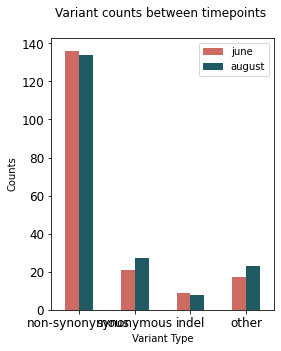

In [13]:
#plt.subplot(2, 1, 1)




panel_b_ann_pivot.plot.bar(x='annotation', y=['june', 'august'], #kind='bar',
                     color=['#cd6a62','#205a62'], 
                   figsize=(4,5),
                   rot=0, grid=False, fontsize=12)


plt.xlabel("Variant Type")
plt.ylabel("Counts")
plt.title("Variant counts between timepoints \n")
plt.savefig('figures/variant_counts.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/variant_counts.pdf', dpi=600, bbox_inches='tight')
plt.savefig('figures/variant_counts.svg', dpi=600, bbox_inches='tight')

plt.show()

## Panel C: nucleotide changes

In [13]:
panel_b_change = merged_df[['timepoint','change']]
panel_b_change

panel_b_change_pivot = (pd.pivot_table(panel_b_change, index=['change'], columns=['timepoint'], aggfunc=len, fill_value=0)
       .reset_index()
       .rename_axis(columns=[None]))

panel_b_change_pivot = panel_b_change_pivot[['change', 'june','august']]

panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('A>C'), 'order'] = 1
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('T>G'), 'order'] = 1
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('A>G'), 'order'] = 2
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('T>C'), 'order'] = 2
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('A>T'), 'order'] = 3
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('T>A'), 'order'] = 3
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('C>A'), 'order'] = 4
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('G>T'), 'order'] = 4
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('C>T'), 'order'] = 5
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('G>A'), 'order'] = 5
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('C>G'), 'order'] = 6
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('G>C'), 'order'] = 6
panel_b_change_pivot.loc[panel_b_change_pivot['change'].str.startswith('other'), 'order'] = 7

panel_b_change_pivot = panel_b_change_pivot.sort_values(['order'], ascending=True)
panel_b_change_pivot

,change,june,august,order
0,A>C,15,14,1.0
11,T>G,10,11,1.0
1,A>G,23,22,2.0
10,T>C,24,25,2.0
2,A>T,4,6,3.0
9,T>A,11,16,3.0
3,C>A,9,12,4.0
8,G>T,6,7,4.0
5,C>T,31,31,5.0
6,G>A,21,18,5.0


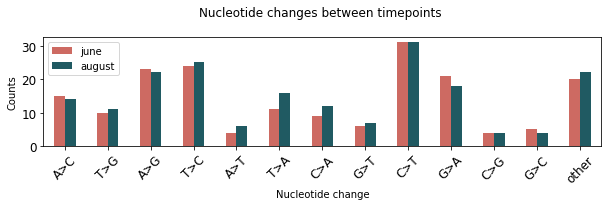

In [14]:
panel_b_change_pivot.plot.bar(x='change', y=['june', 'august'], #kind='bar',
                     color=['#cd6a62','#205a62'], 
                   figsize=(10,2),
                   rot=45, grid=False, fontsize=12)


plt.xlabel("Nucleotide change")
plt.ylabel("Counts")
plt.title("Nucleotide changes between timepoints \n")
plt.savefig('figures/variant_changes_counts.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/variant_changes_counts.pdf', dpi=600, bbox_inches='tight')
plt.savefig('figures/variant_changes_counts.svg', dpi=600, bbox_inches='tight')

plt.show()

In [326]:
nt_changes = panel_b_change_pivot[['change','june','august']]
nt_changes.to_csv('nt_changes_per_month.csv', sep='\t')
df = nt_changes[['change', 'june']]
df = df.set_index('change')
df = df.T
df.columns

Index(['A>C', 'T>G', 'A>G', 'T>C', 'A>T', 'T>A', 'C>A', 'G>T', 'C>T', 'G>A',
       'C>G', 'G>C', 'other'],
      dtype='object', name='change')

In [94]:
# function to get confidence intervals as suggested by Dr. Katia Koelle
def get_nt_change_ci(exp, control, timepoint, ci):
    df = pd.read_csv('nt_changes_per_month.csv', sep='\t')
    df = df[['change', 'june', 'august']]
    june_total = df['june'].sum()
    august_total = df['august'].sum()
    df_month = df[['change', timepoint]]
    data_m = []
    experimental_m  = df_month[df_month['change']==exp]
    control_m = df_month[df_month['change']==control]
    data = [experimental_m, control_m]
    data = pd.concat(data)
    data = pd.DataFrame(data)
    data = data.set_index('change')
    data = data.T
    data
    for index, row in data.iterrows():
        result_m = relative_risk(row[0], june_total, row[1], june_total)
        conf_m = result_m.confidence_interval(confidence_level=ci)
        low_m = conf_m.low
        high_m = conf_m.high
        count = row[0]
        data_m.append(
             {
                 'change':exp,
                 'timepoint': timepoint,
                 'count':count,
                 'low_CI_95': low_m,
                 'high_CI_95':high_m,

             })
    change_ci_m = pd.DataFrame(data_m)
    change_ci_m.to_csv('nt_cis/ci_for_'+exp+'_'+timepoint+'.csv', sep='\t')

In [96]:
get_nt_change_ci('A>C', 'C>A', 'june', .95)
get_nt_change_ci('C>A', 'A>C', 'june', .95)

get_nt_change_ci('A>G', 'G>A', 'june', .95)
get_nt_change_ci('G>A', 'A>G', 'june', .95)

get_nt_change_ci('A>T', 'T>A', 'june', .95)
get_nt_change_ci('T>A', 'A>T', 'june', .95)

get_nt_change_ci('C>G', 'G>C', 'june', .95)
get_nt_change_ci('G>C', 'C>G', 'june', .95)

get_nt_change_ci('C>T', 'T>C', 'june', .95)
get_nt_change_ci('T>C', 'C>T', 'june', .95)

get_nt_change_ci('T>G', 'G>T', 'june', .95)
get_nt_change_ci('G>T', 'T>G', 'june', .95)


In [97]:
get_nt_change_ci('A>C', 'C>A', 'august', .95)
get_nt_change_ci('C>A', 'A>C', 'august', .95)

get_nt_change_ci('A>G', 'G>A', 'august', .95)
get_nt_change_ci('G>A', 'A>G', 'august', .95)

get_nt_change_ci('A>T', 'T>A', 'august', .95)
get_nt_change_ci('T>A', 'A>T', 'august', .95)

get_nt_change_ci('C>G', 'G>C', 'august', .95)
get_nt_change_ci('G>C', 'C>G', 'august', .95)

get_nt_change_ci('C>T', 'T>C', 'august', .95)
get_nt_change_ci('T>C', 'C>T', 'august', .95)

get_nt_change_ci('T>G', 'G>T', 'august', .95)
get_nt_change_ci('G>T', 'T>G', 'august', .95)

In [110]:
#concatenate all files into a single dataframe
folder='nt_cis/'
all_files = glob.glob(os.path.join(folder, "**.csv")) 
df_from_each_file = (pd.read_csv(f, sep='\t') for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)
changes_ci = concatenated_df[['change', 'timepoint', 'count', 'low_CI_95','high_CI_95']]
changes_ci.to_csv('nt_change_ci.csv', sep='\t', index=False)

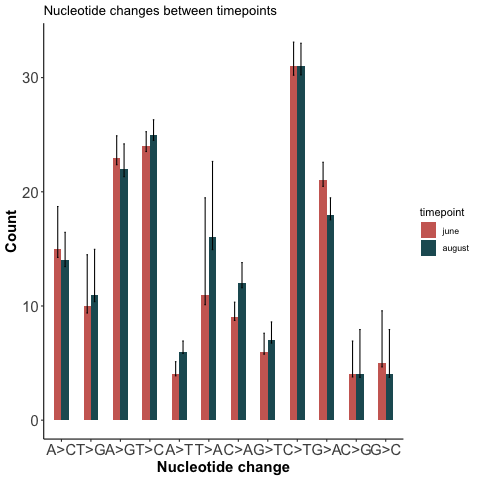

In [114]:
%%R

# load the ggplot2 library
library(ggplot2)

nt_data <- read.table(file = 'nt_change_ci.csv', sep = '\t', header = TRUE)
nt_data <- nt_data[c('change', 'timepoint','count','low_CI_95', 'high_CI_95')]
nt_data$change <- factor(nt_data$change,levels = c('A>C', 'T>G', 'A>G', 'T>C', 'A>T', 'T>A', 'C>A', 
                                                   'G>T', 'C>T', 'G>A','C>G', 'G>C', 'other'))
nt_data$timepoint <- factor(nt_data$timepoint,levels = c('june', 'august'))



plot_nt <- ggplot(nt_data, aes(x=change, y=count, fill=timepoint),fig(12,3))+
  geom_bar(width=0.5,position=position_dodge(), stat="identity")+
  geom_errorbar(aes(ymin=count-low_CI_95, ymax=count+high_CI_95),
                width=.1,                    # Width of the error bars
                position=position_dodge(0.5)) +
  scale_color_grey() + theme_classic() +
  scale_fill_manual(values=c('#cd6a62','#205a62'))+
  labs(title="Nucleotide changes between timepoints", y="Count", x="Nucleotide change") +
  theme(plot.caption=element_text(size=15), axis.title.x=element_text(size=15, face="bold"), axis.title.y=element_text(size=15, face="bold"),
        axis.text.x=element_text(size=15), axis.text.y=element_text(size=15))

ggsave('figures/nt_changes_with_ci.pdf', dpi=300, width = 12, height = 3, units = 'in' ) 
print(plot_nt)
# The figure looks weird here, but it saves in the right format

## Panel D: per site variant with CI

In [58]:
panel_b_gene = merged_df[['timepoint','GENE','annotation']]

panel_b_gene_pivot = (pd.pivot_table(panel_b_gene, index=['timepoint', 'GENE'], columns=['annotation'], aggfunc=len, fill_value=0)
       .reset_index()
       .rename_axis(columns=[None]))

panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('orf1ab'), 'order'] = 1
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('E'), 'order'] = 4
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('S'), 'order'] = 2
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('M'), 'order'] = 5
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('N'), 'order'] = 9
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF10'), 'order'] = 10
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF3a'), 'order'] = 3
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF6'), 'order'] = 6
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF7a'), 'order'] = 7
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF8'), 'order'] = 8

panel_b_gene_pivot = panel_b_gene_pivot.sort_values(['timepoint','order'], ascending=[False, True])

#panel_b_gene_pivot = panel_b_gene_pivot[['annotation', 'june','august']]
#panel_b_gene_pivot

panel_b_gene_pivot = panel_b_gene_pivot[['timepoint', 'GENE', 'indel', 'non-synonymous','synonymous']]
panel_b_gene_pivot .head(2)

,timepoint,GENE,indel,non-synonymous,synonymous
15,june,orf1ab,4,59,17
14,june,S,2,59,1


In [59]:
frames = [june_df, august_df]

merged_df = pd.concat(frames)

panel_b_gene = merged_df[['timepoint','GENE','annotation']]

panel_b_gene_pivot = (pd.pivot_table(panel_b_gene, index=['timepoint', 'GENE'], columns=['annotation'], aggfunc=len, fill_value=0)
       .reset_index()
       .rename_axis(columns=[None]))
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('orf1ab'), 'order'] = 1
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('E'), 'order'] = 4
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('S'), 'order'] = 2
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('M'), 'order'] = 5
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('N'), 'order'] = 9
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF10'), 'order'] = 10
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF3a'), 'order'] = 3
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF6'), 'order'] = 6
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF7a'), 'order'] = 7
panel_b_gene_pivot.loc[panel_b_gene_pivot['GENE'].str.startswith('ORF8'), 'order'] = 8

panel_b_gene_pivot = panel_b_gene_pivot.sort_values(['timepoint','order'], ascending=[False, True])
panel_b_gene_pivot_jun = panel_b_gene_pivot[panel_b_gene_pivot['timepoint']=='june']
panel_b_gene_pivot_aug = panel_b_gene_pivot[panel_b_gene_pivot['timepoint']=='august']



In [60]:
june_timepoint = pd.read_csv('timepoints/D3_20220616/SNPGenie_Results/product_results.txt', sep='\t')

june_timepoint.loc[june_timepoint['product'].str.startswith('gene-orf1ab'), 'GENE'] = 'orf1ab'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-E'), 'GENE'] = 'E'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-S'), 'GENE'] = 'S'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-M'), 'GENE'] = 'M'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-N'), 'GENE'] = 'N'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-ORF10'), 'GENE'] = 'ORF10'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-ORF3a'), 'GENE'] = 'ORF3a'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-ORF6'), 'GENE'] = 'ORF6'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-ORF7a'), 'GENE'] = 'ORF7a'
june_timepoint.loc[june_timepoint['product'].str.startswith('gene-ORF8'), 'GENE'] = 'ORF8'

june_timepoint = june_timepoint[['GENE', 'N_sites', 'S_sites']]

june_per_site = pd.merge(panel_b_gene_pivot_jun, june_timepoint,how='outer')
june_per_site['timepoint'] = 'june'
june_per_site = june_per_site.fillna(0)

june_per_site['N_per_site_j'] = june_per_site['non-synonymous']/june_per_site['N_sites']
june_per_site['S_per_site_j'] = june_per_site['synonymous']/june_per_site['S_sites']

june_per_site.to_csv('timepoints/D3_20220616/muts_per_site_june.csv', sep = '\t')

june_per_site = june_per_site[['timepoint', 'GENE', 'indel','N_per_site_j', 'S_per_site_j','order']]

In [61]:
august_timepoint = pd.read_csv('timepoints/D3_20220816/SNPGenie_Results/product_results.txt', sep='\t')

august_timepoint.loc[august_timepoint['product'].str.startswith('gene-orf1ab'), 'GENE'] = 'orf1ab'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-E'), 'GENE'] = 'E'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-S'), 'GENE'] = 'S'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-M'), 'GENE'] = 'M'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-N'), 'GENE'] = 'N'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-ORF10'), 'GENE'] = 'ORF10'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-ORF3a'), 'GENE'] = 'ORF3a'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-ORF6'), 'GENE'] = 'ORF6'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-ORF7a'), 'GENE'] = 'ORF7a'
august_timepoint.loc[august_timepoint['product'].str.startswith('gene-ORF8'), 'GENE'] = 'ORF8'

august_timepoint = august_timepoint[['GENE', 'N_sites', 'S_sites']]

august_per_site = pd.merge(panel_b_gene_pivot_aug, august_timepoint,how='outer')
august_per_site['timepoint'] = 'august'
august_per_site = august_per_site.fillna(0)

august_per_site['N_per_site_a'] = august_per_site['non-synonymous']/august_per_site['N_sites']
august_per_site['S_per_site_a'] = august_per_site['synonymous']/august_per_site['S_sites']
august_per_site.to_csv('timepoints/D3_20220816//muts_per_site_august.csv', sep = '\t')

august_per_site = august_per_site[['timepoint', 'GENE', 'indel','N_per_site_a', 'S_per_site_a','order']]

august_per_site

,timepoint,GENE,indel,N_per_site_a,S_per_site_a,order
0,august,orf1ab,4.0,0.003482,0.004472,1.0
1,august,S,2.0,0.019826,0.002238,2.0
2,august,ORF3a,0.0,0.011149,0.005073,3.0
3,august,M,1.0,0.007944,0.000000,5.0
4,august,ORF6,0.0,0.006849,0.000000,6.0
5,august,ORF7a,0.0,0.007298,0.000000,7.0
6,august,ORF8,1.0,0.000000,0.000000,8.0
7,august,N,0.0,0.005215,0.006705,9.0
8,august,E,0.0,0.000000,0.000000,0.0
9,august,ORF10,0.0,0.000000,0.000000,0.0


In [62]:

'''
binomtest(x,n, p, alternative) returns a maximum likelihood estimate of the probability of success in a 
given binomial trial based on the number of successes, "x", observed in "n" independent trials

x(int) =  The number of successes.
n(int) =  The number of trials.
p(float), optional = The hypothesized probability of success, i.e. the expected proportion of successes. 
    The value must be in the interval 0 <= p <= 1. The default value is p = 0.5.
alternative {‘two-sided’, ‘greater’, ‘less’}, optional = Indicates the alternative hypothesis. 
    The default value is ‘two-sided’.
'''

# testing the function
result = binomtest(0, n=200)#, p=0.1)#, alternative='greater')

print(result)
print(result.pvalue)
conf = result.proportion_ci(confidence_level=0.95)




BinomTestResult(k=0, n=200, alternative='two-sided', proportion_estimate=0.0, pvalue=1.2446030555722283e-60)
1.2446030555722283e-60


In [63]:
# non_syn
def getting_95_ci_nsyn(path,file, ci):
    
    df= pd.read_csv(path+file, sep='\t')
    df = df[['timepoint','GENE', 'non-synonymous','N_sites', 'synonymous','S_sites']]
    df.N_sites = df.N_sites.round()
    df.N_sites = df.N_sites.astype(int)
    df.S_sites = df.S_sites.round()
    df.S_sites = df.S_sites.astype(int)
    df['non-synonymous'] = df['non-synonymous'].astype(int)
    df.synonymous = df.synonymous.astype(int)
    #print(df)
    data = []
    for index, row in df.iterrows():
        #print(row[2], row[3])
        result = binomtest(row[2], row[3])
        conf = result.proportion_ci(confidence_level=ci)
        low = conf.low
        high = conf.high
        sample = row[0] 
        gene = row[1]
        data.append(
        {
            'timepoint':sample,
            'gene':gene,
            'low (ci 95%)ns': low,
            'high (ci 95%)ns':high
            
        })
        
    frame_timepoint = pd.DataFrame(data)
    #print(frame_timepoint)
    frame_timepoint.to_csv(path+'confidence_intervals_per_gene_nonsyn.csv', sep='\t')

        
# syn
def getting_95_ci_syn(path,file, ci):
   
    df= pd.read_csv(path+file, sep='\t')
    df = df[['timepoint','GENE', 'non-synonymous','N_sites', 'synonymous','S_sites']]
    df.N_sites = df.N_sites.round()
    df.N_sites = df.N_sites.astype(int)
    df.S_sites = df.S_sites.round()
    df.S_sites = df.S_sites.astype(int)
    df['non-synonymous'] = df['non-synonymous'].astype(int)
    df.synonymous = df.synonymous.astype(int)
    #print(df)
    data = []
    for index, row in df.iterrows():
        #print(row[2], row[3])
        result = binomtest(row[4], row[5])
        conf = result.proportion_ci(confidence_level=ci)
        low = conf.low
        high = conf.high
        sample = row[0] 
        gene = row[1]
        data.append(
        {
            'timepoint':sample,
            'gene':gene,
            'low (ci 95%)s': low,
            'high (ci 95%)s':high
            
        })
        
    frame_timepoint = pd.DataFrame(data)
    #print(frame_timepoint)
    frame_timepoint.to_csv(path+'confidence_intervals_per_gene_syn.csv', sep='\t')

        
      

In [64]:
getting_95_ci_syn('timepoints/D3_20220816/','muts_per_site_august.csv', 0.95)
getting_95_ci_syn('timepoints/D3_20220616/','muts_per_site_june.csv', 0.95)
getting_95_ci_nsyn('timepoints/D3_20220816/','muts_per_site_august.csv', 0.95)
getting_95_ci_nsyn('timepoints/D3_20220616/','muts_per_site_june.csv', 0.95)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:73: RuntimeWarning: divide by zero encountered in _binom_cdf
  return _boost._binom_cdf(k, n, p)


In [66]:
jun_syn_ci = pd.read_csv('timepoints/D3_20220616/confidence_intervals_per_gene_syn.csv', sep='\t')
jun_nsyn_ci = pd.read_csv('timepoints/D3_20220616/confidence_intervals_per_gene_nonsyn.csv', sep='\t')

june_ci = pd.merge(jun_syn_ci,jun_nsyn_ci, how='inner', on=['timepoint','gene'])

june_ci.rename(columns={'low (ci 95%)s':'low_ci_95_syn', 'high (ci 95%)s':'high_ci_95_syn',
                          'low (ci 95%)ns':'low_ci_95_nsyn', 'high (ci 95%)ns':'high_ci_95_nsyn',
                          'gene':'GENE'}, inplace=True)
june_ci = june_ci[['timepoint', 'GENE', 'low_ci_95_syn', 'high_ci_95_syn',
                      'low_ci_95_nsyn', 'high_ci_95_nsyn']]
june_ci.head(3)

,timepoint,GENE,low_ci_95_syn,high_ci_95_syn,low_ci_95_nsyn,high_ci_95_nsyn
0,june,orf1ab,0.002014,0.005528,0.002745,0.004647
1,june,S,0.000028,0.006230,0.015379,0.025925
2,june,ORF3a,0.000129,0.027956,0.003514,0.020679


In [65]:
aug_syn_ci = pd.read_csv('timepoints/D3_20220816/confidence_intervals_per_gene_syn.csv', sep='\t')
aug_nsyn_ci = pd.read_csv('timepoints/D3_20220816/confidence_intervals_per_gene_nonsyn.csv', sep='\t')

august_ci = pd.merge(aug_syn_ci,aug_nsyn_ci, how='inner', on=['timepoint','gene'])

august_ci.rename(columns={'low (ci 95%)s':'low_ci_95_syn', 'high (ci 95%)s':'high_ci_95_syn',
                          'low (ci 95%)ns':'low_ci_95_nsyn', 'high (ci 95%)ns':'high_ci_95_nsyn',
                          'gene':'GENE'}, inplace=True)
august_ci = august_ci[['timepoint', 'GENE', 'low_ci_95_syn', 'high_ci_95_syn',
                      'low_ci_95_nsyn', 'high_ci_95_nsyn']]
august_ci.head(3)

,timepoint,GENE,low_ci_95_syn,high_ci_95_syn,low_ci_95_nsyn,high_ci_95_nsyn
0,august,orf1ab,0.002805,0.006764,0.002639,0.004510
1,august,S,0.000271,0.008058,0.015091,0.025559
2,august,ORF3a,0.000129,0.027956,0.004493,0.022831


In [68]:
aug_with_ci = pd.merge(august_per_site,august_ci, how='inner', on=['timepoint','GENE'])
jun_with_ci = pd.merge(june_per_site,june_ci, how='inner', on=['timepoint','GENE'])


aug_with_ci.rename(columns={'N_per_site_a':'N_per_site', 'S_per_site_a':'S_per_site'}, inplace=True)
jun_with_ci.rename(columns={'N_per_site_j':'N_per_site', 'S_per_site_j':'S_per_site'}, inplace=True)

aug_with_ci.to_csv('timepoints/per_site_values_with_ci_aug.csv',sep='\t')
jun_with_ci.to_csv('timepoints/per_site_values_with_ci_jun.csv',sep='\t')

aug_with_ci

,timepoint,GENE,indel,N_per_site,S_per_site,order,low_ci_95_syn,high_ci_95_syn,low_ci_95_nsyn,high_ci_95_nsyn
0,august,orf1ab,4.0,0.003482,0.004472,1.0,0.002805,0.006764,0.002639,0.004510
1,august,S,2.0,0.019826,0.002238,2.0,0.000271,0.008058,0.015091,0.025559
2,august,ORF3a,0.0,0.011149,0.005073,3.0,0.000129,0.027956,0.004493,0.022831
3,august,M,1.0,0.007944,0.000000,5.0,0.000000,0.022514,0.002167,0.020195
4,august,ORF6,0.0,0.006849,0.000000,6.0,0.000000,0.094891,0.000173,0.037570
5,august,ORF7a,0.0,0.007298,0.000000,7.0,0.000000,0.040601,0.000885,0.026117
6,august,ORF8,1.0,0.000000,0.000000,8.0,0.000000,0.043989,0.000000,0.013088
7,august,N,0.0,0.005215,0.006705,9.0,0.000814,0.024032,0.001695,0.012125
8,august,E,0.0,0.000000,0.000000,0.0,0.000000,0.058681,0.000000,0.022242
9,august,ORF10,0.0,0.000000,0.000000,0.0,0.000000,0.132275,0.000000,0.041053


In [69]:
merged_per_site = pd.merge(aug_with_ci, jun_with_ci,how='outer')

merged_per_site['sterr_N'] = (merged_per_site['high_ci_95_nsyn']-merged_per_site['low_ci_95_nsyn'])/3.92
merged_per_site['sterr_S'] = (merged_per_site['high_ci_95_syn']-merged_per_site['low_ci_95_syn'])/3.92

merged_per_site.head(2)

,timepoint,GENE,indel,N_per_site,S_per_site,order,low_ci_95_syn,high_ci_95_syn,low_ci_95_nsyn,high_ci_95_nsyn,sterr_N,sterr_S
0,august,orf1ab,4.0,0.003482,0.004472,1.0,0.002805,0.006764,0.002639,0.004510,0.000477,0.001010
1,august,S,2.0,0.019826,0.002238,2.0,0.000271,0.008058,0.015091,0.025559,0.002671,0.001986


In [70]:
merged_per_site = merged_per_site[['timepoint','GENE', 
                                   'N_per_site', 'sterr_N','low_ci_95_nsyn','high_ci_95_nsyn',
                                   'S_per_site', 'sterr_S','low_ci_95_syn', 'high_ci_95_syn', 'indel'
                                   ]]


In [71]:
merged_per_site.head(3)

,timepoint,GENE,N_per_site,sterr_N,low_ci_95_nsyn,high_ci_95_nsyn,S_per_site,sterr_S,low_ci_95_syn,high_ci_95_syn,indel
0,august,orf1ab,0.003482,0.000477,0.002639,0.004510,0.004472,0.001010,0.002805,0.006764,4.0
1,august,S,0.019826,0.002671,0.015091,0.025559,0.002238,0.001986,0.000271,0.008058,2.0
2,august,ORF3a,0.011149,0.004678,0.004493,0.022831,0.005073,0.007099,0.000129,0.027956,0.0


In [72]:
merged_per_site_pivot = (pd.pivot_table(merged_per_site, index=['GENE']))
#       .reset_index()
#       .rename_axis(columns=[None])


merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('orf1ab'), 'order'] = 1
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('E'), 'order'] = 4
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('S'), 'order'] = 2
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('M'), 'order'] = 5
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('N'), 'order'] = 9
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('ORF10'), 'order'] = 10
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('ORF3a'), 'order'] = 3
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('ORF6'), 'order'] = 6
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('ORF7a'), 'order'] = 7
merged_per_site_pivot.loc[merged_per_site_pivot.index.str.startswith('ORF8'), 'order'] = 8

merged_per_site_pivot = merged_per_site_pivot.sort_values(['order'], ascending=[True])


merged_per_site_pivot.to_csv('timepoints/per_site_values_with_ci.csv',sep='\t')
merged_per_site_pivot

,N_per_site,S_per_site,high_ci_95_nsyn,high_ci_95_syn,indel,low_ci_95_nsyn,low_ci_95_syn,sterr_N,sterr_S,order
GENE,,,,,,,,,,
orf1ab,0.003543,0.003964,0.004578,0.006146,4.0,0.002692,0.002410,0.000481,0.000953,1.0
S,0.019991,0.001680,0.025742,0.007144,2.0,0.015235,0.000150,0.002680,0.001784,2.0
ORF3a,0.010350,0.005077,0.021755,0.027956,0.0,0.004003,0.000129,0.004528,0.007099,3.0
E,0.000000,0.000000,0.022242,0.058681,0.0,0.000000,0.000000,0.005674,0.014970,4.0
M,0.007945,0.000000,0.020215,0.022445,1.0,0.002169,0.000000,0.004604,0.005726,5.0
ORF6,0.006849,0.000000,0.037570,0.094891,0.0,0.000173,0.000000,0.009540,0.024207,6.0
ORF7a,0.007297,0.000000,0.026117,0.040601,0.0,0.000885,0.000000,0.006437,0.010357,7.0
ORF8,0.000000,0.000000,0.013088,0.043989,1.0,0.000000,0.000000,0.003339,0.011222,8.0
N,0.005214,0.006709,0.012125,0.024032,0.5,0.001695,0.000814,0.002661,0.005923,9.0


In [73]:
aug_syn_ci = pd.read_csv('timepoints/D3_20220816/confidence_intervals_per_gene_syn.csv', sep='\t')
aug_nsyn_ci = pd.read_csv('timepoints/D3_20220816/confidence_intervals_per_gene_nonsyn.csv', sep='\t')

aug_syn_ci.rename(columns={'low (ci 95%)s':'low_ci_95', 'high (ci 95%)s':'high_ci_95',
                          'gene':'GENE'}, inplace=True)
aug_nsyn_ci.rename(columns={'low (ci 95%)ns':'low_ci_95', 'high (ci 95%)ns':'high_ci_95',
                          'gene':'GENE'}, inplace=True)
aug_syn_ci['type'] = 'synonymous'
aug_nsyn_ci['type'] = 'nonsynonymous'

august_ci = pd.concat([aug_syn_ci,aug_nsyn_ci], axis=0)


august_ci

,Unnamed: 0,timepoint,GENE,low_ci_95,high_ci_95,type
0,0,august,orf1ab,0.002805,0.006764,synonymous
1,1,august,S,0.000271,0.008058,synonymous
2,2,august,ORF3a,0.000129,0.027956,synonymous
3,3,august,M,0.000000,0.022514,synonymous
4,4,august,ORF6,0.000000,0.094891,synonymous
5,5,august,ORF7a,0.000000,0.040601,synonymous
6,6,august,ORF8,0.000000,0.043989,synonymous
7,7,august,N,0.000814,0.024032,synonymous
8,8,august,E,0.000000,0.058681,synonymous
9,9,august,ORF10,0.000000,0.132275,synonymous


In [74]:
jun_syn_ci = pd.read_csv('timepoints/D3_20220616/confidence_intervals_per_gene_syn.csv', sep='\t')
jun_nsyn_ci = pd.read_csv('timepoints/D3_20220616/confidence_intervals_per_gene_nonsyn.csv', sep='\t')

jun_syn_ci.rename(columns={'low (ci 95%)s':'low_ci_95', 'high (ci 95%)s':'high_ci_95',
                          'gene':'GENE'}, inplace=True)
jun_nsyn_ci.rename(columns={'low (ci 95%)ns':'low_ci_95', 'high (ci 95%)ns':'high_ci_95',
                          'gene':'GENE'}, inplace=True)
jun_syn_ci['type'] = 'synonymous'
jun_nsyn_ci['type'] = 'nonsynonymous'

june_ci = pd.concat([jun_syn_ci,jun_nsyn_ci], axis=0)


june_ci

,Unnamed: 0,timepoint,GENE,low_ci_95,high_ci_95,type
0,0,june,orf1ab,0.002014,0.005528,synonymous
1,1,june,S,0.000028,0.006230,synonymous
2,2,june,ORF3a,0.000129,0.027956,synonymous
3,3,june,M,0.000000,0.022377,synonymous
4,4,june,ORF6,0.000000,0.094891,synonymous
5,5,june,ORF7a,0.000000,0.040601,synonymous
6,6,june,ORF8,0.000000,0.043989,synonymous
7,7,june,N,0.000814,0.024032,synonymous
8,8,june,E,0.000000,0.058681,synonymous
9,9,june,ORF10,0.000000,0.132275,synonymous


In [75]:
timepoints_ci = pd.concat([june_ci,august_ci], axis=0)
timepoints_ci = timepoints_ci[['timepoint','type', 'GENE', 'low_ci_95', 'high_ci_95']]
timepoints_ci['sample'] = timepoints_ci['timepoint'] + '_' + timepoints_ci['type']
timepoints_ci

timepoints_ci.to_csv('timepoints_all_ci.csv', sep='\t')

In [76]:
aug_with_ci

,timepoint,GENE,indel,N_per_site,S_per_site,order,low_ci_95_syn,high_ci_95_syn,low_ci_95_nsyn,high_ci_95_nsyn
0,august,orf1ab,4.0,0.003482,0.004472,1.0,0.002805,0.006764,0.002639,0.004510
1,august,S,2.0,0.019826,0.002238,2.0,0.000271,0.008058,0.015091,0.025559
2,august,ORF3a,0.0,0.011149,0.005073,3.0,0.000129,0.027956,0.004493,0.022831
3,august,M,1.0,0.007944,0.000000,5.0,0.000000,0.022514,0.002167,0.020195
4,august,ORF6,0.0,0.006849,0.000000,6.0,0.000000,0.094891,0.000173,0.037570
5,august,ORF7a,0.0,0.007298,0.000000,7.0,0.000000,0.040601,0.000885,0.026117
6,august,ORF8,1.0,0.000000,0.000000,8.0,0.000000,0.043989,0.000000,0.013088
7,august,N,0.0,0.005215,0.006705,9.0,0.000814,0.024032,0.001695,0.012125
8,august,E,0.0,0.000000,0.000000,0.0,0.000000,0.058681,0.000000,0.022242
9,august,ORF10,0.0,0.000000,0.000000,0.0,0.000000,0.132275,0.000000,0.041053


In [77]:
aug_with_ci.to_csv('timepoints/per_site_values_with_ci_aug.csv',sep='\t')

aug_with_ci = aug_with_ci[['timepoint', 'GENE', 'N_per_site', 'S_per_site']]
aug_with_ci_s = aug_with_ci[['timepoint', 'GENE', 'S_per_site']]
aug_with_ci_ns = aug_with_ci[['timepoint', 'GENE', 'N_per_site']]

aug_with_ci_s['type'] = 'synonymous'
aug_with_ci_s['sample'] = aug_with_ci_s['timepoint'] + '_' + aug_with_ci_s['type']
aug_with_ci_s.rename(columns={'S_per_site':'per_site_value'}, inplace=True)

aug_with_ci_ns['type'] = 'nonsynonymous'
aug_with_ci_ns['sample'] = aug_with_ci_ns['timepoint'] + '_' + aug_with_ci_ns['type']
aug_with_ci_ns.rename(columns={'N_per_site':'per_site_value'}, inplace=True)



values_aug_ci = pd.concat([aug_with_ci_s,aug_with_ci_ns], axis=0)
values_aug_ci

,timepoint,GENE,per_site_value,type,sample
0,august,orf1ab,0.004472,synonymous,august_synonymous
1,august,S,0.002238,synonymous,august_synonymous
2,august,ORF3a,0.005073,synonymous,august_synonymous
3,august,M,0.000000,synonymous,august_synonymous
4,august,ORF6,0.000000,synonymous,august_synonymous
5,august,ORF7a,0.000000,synonymous,august_synonymous
6,august,ORF8,0.000000,synonymous,august_synonymous
7,august,N,0.006705,synonymous,august_synonymous
8,august,E,0.000000,synonymous,august_synonymous
9,august,ORF10,0.000000,synonymous,august_synonymous


In [78]:
jun_with_ci.to_csv('timepoints/per_site_values_with_ci_jun.csv',sep='\t')


jun_with_ci = jun_with_ci[['timepoint', 'GENE', 'N_per_site', 'S_per_site']]
jun_with_ci_s = jun_with_ci[['timepoint', 'GENE', 'S_per_site']]
jun_with_ci_ns = jun_with_ci[['timepoint', 'GENE', 'N_per_site']]

jun_with_ci_s['type'] = 'synonymous'
jun_with_ci_s['sample'] = jun_with_ci_s['timepoint'] + '_' + jun_with_ci_s['type']
jun_with_ci_s.rename(columns={'S_per_site':'per_site_value'}, inplace=True)

jun_with_ci_ns['type'] = 'nonsynonymous'
jun_with_ci_ns['sample'] = jun_with_ci_ns['timepoint'] + '_' + jun_with_ci_ns['type']
jun_with_ci_ns.rename(columns={'N_per_site':'per_site_value'}, inplace=True)



values_jun_ci = pd.concat([jun_with_ci_s,jun_with_ci_ns], axis=0)
values_jun_ci

,timepoint,GENE,per_site_value,type,sample
0,june,orf1ab,0.003456,synonymous,june_synonymous
1,june,S,0.001121,synonymous,june_synonymous
2,june,ORF3a,0.005081,synonymous,june_synonymous
3,june,M,0.000000,synonymous,june_synonymous
4,june,ORF6,0.000000,synonymous,june_synonymous
5,june,ORF7a,0.000000,synonymous,june_synonymous
6,june,ORF8,0.000000,synonymous,june_synonymous
7,june,N,0.006712,synonymous,june_synonymous
8,june,E,0.000000,synonymous,june_synonymous
9,june,ORF10,0.000000,synonymous,june_synonymous


In [79]:
values_ci = pd.concat([values_jun_ci,values_aug_ci], axis=0)

values_ci = values_ci[['timepoint','sample','type', 'GENE', 'per_site_value']]
values_ci.to_csv('values_all_ci.csv', sep='\t')
values_ci

,timepoint,sample,type,GENE,per_site_value
0,june,june_synonymous,synonymous,orf1ab,0.003456
1,june,june_synonymous,synonymous,S,0.001121
2,june,june_synonymous,synonymous,ORF3a,0.005081
3,june,june_synonymous,synonymous,M,0.000000
4,june,june_synonymous,synonymous,ORF6,0.000000
5,june,june_synonymous,synonymous,ORF7a,0.000000
6,june,june_synonymous,synonymous,ORF8,0.000000
7,june,june_synonymous,synonymous,N,0.006712
8,june,june_synonymous,synonymous,E,0.000000
9,june,june_synonymous,synonymous,ORF10,0.000000


In [81]:
final_table = pd.merge(values_ci,timepoints_ci, how='inner', on=['timepoint','GENE','type','sample'])
final_table = final_table[[ 'sample', 'GENE', 'per_site_value', 'low_ci_95',
       'high_ci_95']]

final_table.loc[final_table['per_site_value'] == 0, 'low_ci_95'] = 0
final_table.loc[final_table['per_site_value'] == 0, 'high_ci_95'] = 0
final_table.to_csv('final_table_with_ci.csv', sep='\t')

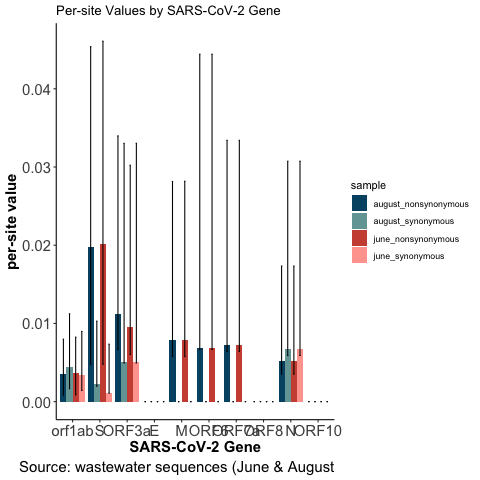

In [360]:
%%R

# load the ggplot2 library
library(ggplot2)

tp_data <- read.table(file = 'final_table_with_ci.csv', sep = '\t', header = TRUE)
tp_data <- tp_data[c('sample','GENE', 'per_site_value','low_ci_95', 'high_ci_95')]

tp_data$GENE <- factor(tp_data$GENE,levels = c("orf1ab","S", "ORF3a", "E", "M", "ORF6","ORF7a","ORF8","N","ORF10"))



plot <- ggplot(tp_data, aes(x=GENE, y=per_site_value, fill=sample),fig(12,3)) +
  geom_bar(width=0.9,position=position_dodge(), stat="identity")+
  geom_errorbar(aes(ymin=per_site_value-low_ci_95, ymax=per_site_value+high_ci_95),
                width=.2,                    # Width of the error bars
                position=position_dodge(0.9)) +
  scale_color_grey() + theme_classic() +
  scale_fill_manual(values=c('#005273', "#73a4a4", "#cd5241","#ffa49c"))+
  labs(title="Per-site Values by SARS-CoV-2 Gene", y="per-site value", x="SARS-CoV-2 Gene", caption="Source: wastewater sequences (June & August") +
  theme(plot.caption=element_text(size=15), axis.title.x=element_text(size=15, face="bold"), axis.title.y=element_text(size=15, face="bold"),
        axis.text.x=element_text(size=15), axis.text.y=element_text(size=15))

ggsave('figures/per_site_with_ci.pdf', dpi=300, width = 12, height = 3, units = 'in' )
print(plot) #looks weird here, but it saves correctly